# Поиск частых наборов

### Постановка задачи
1. Реализовать алгоритм Apriori для поиска частых наборов элементов в заданном наборе данных.
2. Провести эксперименты с разными порогами поддержки (например: 1%, 3%, 5%, 10%, 15%).
3. Визуализировать результаты в виде двух диаграмм:  
    * Сравнение времени выполнения при изменении порога поддержки.  
    * Количество частых наборов элементов различной длины при изменении порога поддержки.  
4. Подготовить отчёт

Импорт необходимых библиотек для выполнения поставленных задач

In [119]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import time
import matplotlib.pyplot as plt
import seaborn as sns

Загрузка данных из датасета

In [120]:
data = pd.read_csv('baskets.csv', header=None, encoding='utf-8')

transactions = []
for i in range(len(data)):
    transaction = [item for item in data.iloc[i] if pd.notna(item)]
    transactions.append(transaction)

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

Объявим функцию, реализующую метод Априори.  
Она имеет практически ту же сигнатуру, что и метод, принимает непосредственно данные и значение минимальной поддержки.  
Результатом этой функции выступает кортеж из результата метода Априори и времени его выполнения.

In [121]:
def run_apriori(df, min_support, sort_method='support'):
    start_time = time.time()
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    end_time = time.time()

    if sort_method == 'support':
        frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
    elif sort_method == 'lexicographic':
        frequent_itemsets['itemsets_str'] = frequent_itemsets['itemsets'].apply(lambda x: str(sorted(list(x))))
        frequent_itemsets = frequent_itemsets.sort_values(by='itemsets_str')
        frequent_itemsets = frequent_itemsets.drop('itemsets_str', axis=1)
    
    return frequent_itemsets, end_time - start_time

Далее выполним требуемые действия и сравним производительность в зависимости от различных порогов поддержки. А также сформируем датафрейм для отображения количества частых наборов.

In [122]:
support_thresholds = [0.01, 0.03, 0.05, 0.1, 0.15]
results = []
execution_times = []

for threshold in support_thresholds:
    freq_items, exec_time = run_apriori(df, threshold, sort_method='lexicographic')
    results.append(freq_items)
    execution_times.append(exec_time)

itemset_counts = []
for res in results:
    counts = res['itemsets'].apply(lambda x: len(x)).value_counts().sort_index()
    itemset_counts.append(counts)

Отобразим полученные результаты.

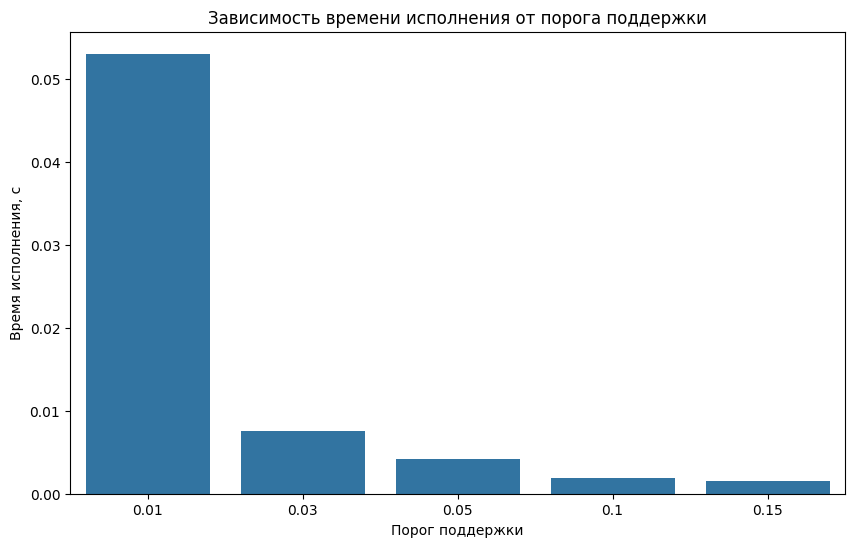

In [123]:
plt.figure(figsize=(10, 6))
sns.barplot(x=support_thresholds, y=execution_times)
plt.xlabel('Порог поддержки')
plt.ylabel('Время исполнения, с')
plt.title('Зависимость времени исполнения от порога поддержки')
plt.show()

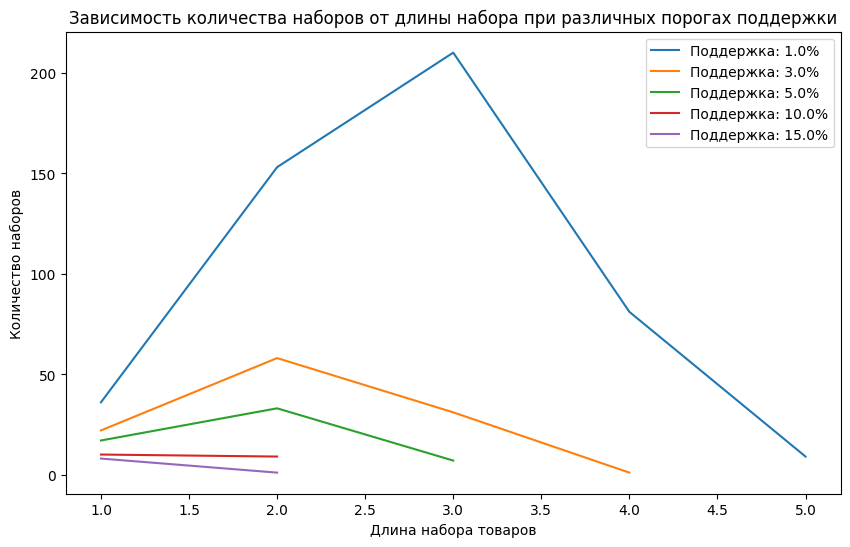

In [124]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, counts in enumerate(itemset_counts):
    ax.plot(counts.index, counts.values, label=f'Поддержка: {support_thresholds[i]*100}%')

ax.set_xlabel('Длина набора товаров')
ax.set_ylabel('Количество наборов')
ax.set_title('Зависимость количества наборов от длины набора при различных порогах поддержки')
ax.legend()
plt.show()

In [125]:
def find_association_rules(df, min_support, min_confidence, sort_method='support'):
    start_time = time.time()
    
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    
    if sort_method == 'support':
        rules = rules.sort_values(by=['support'], ascending=False)
    elif sort_method == 'lexicographic':
        rules['antecedents_str'] = rules['antecedents'].apply(lambda x: str(sorted(list(x))))
        rules['consequents_str'] = rules['consequents'].apply(lambda x: str(sorted(list(x))))
        rules = rules.sort_values(by=['antecedents_str', 'consequents_str'])
        rules = rules.drop(['antecedents_str', 'consequents_str'], axis=1)
    
    end_time = time.time()
    return rules, end_time - start_time

def display_rules(rules, max_rules=10):
    pd.set_option('display.max_colwidth', None)
    
    display_df = rules.copy()
    display_df['antecedents'] = display_df['antecedents'].apply(lambda x: ', '.join(list(x)))
    display_df['consequents'] = display_df['consequents'].apply(lambda x: ', '.join(list(x)))
    display_df['rule'] = display_df['antecedents'] + ' → ' + display_df['consequents']
    result_df = display_df[['rule', 'support', 'confidence']]
    
    return result_df.head(max_rules)

def filter_rules_by_size(rules, max_total_items=7):
    filtered_rules = rules[rules.apply(lambda x: len(x['antecedents']) + len(x['consequents']) <= max_total_items, axis=1)]
    return filtered_rules

In [126]:
support_threshold = 0.01
results = []
execution_times = []
rule_counts = []
confidence_thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

sort_method = 'support'

for threshold in confidence_thresholds:
    rules, exec_time = find_association_rules(df, support_threshold, threshold, sort_method=sort_method)
    results.append(rules)
    execution_times.append(exec_time)
    rule_counts.append(len(rules))

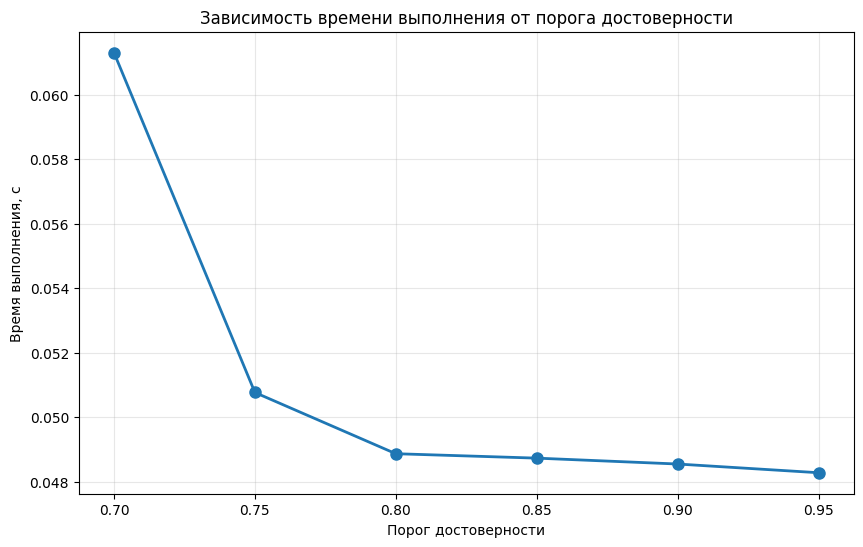

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(confidence_thresholds, execution_times, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Порог достоверности')
plt.ylabel('Время выполнения, с')
plt.title('Зависимость времени выполнения от порога достоверности')
plt.xticks(confidence_thresholds)
plt.grid(True, alpha=0.3)
plt.show()

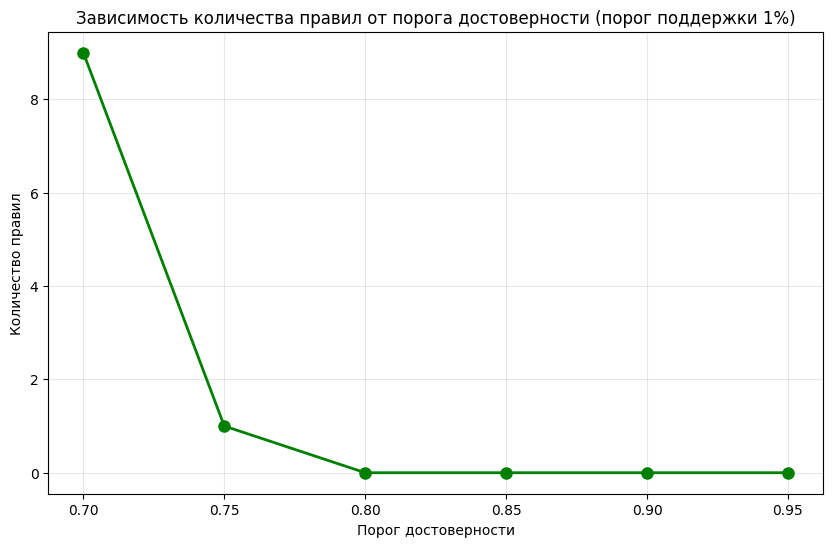

In [128]:
plt.figure(figsize=(10, 6))
plt.plot(confidence_thresholds, rule_counts, marker='o', linestyle='-', linewidth=2, markersize=8, color='green', label='Количество правил')

plt.xlabel('Порог достоверности')
plt.ylabel('Количество правил')
plt.title('Зависимость количества правил от порога достоверности (порог поддержки 1%)')
plt.xticks(confidence_thresholds)
plt.grid(True, alpha=0.3)
plt.show()

In [129]:
filtered_rules = filter_rules_by_size(results[0], max_total_items=7)
display_rules(filtered_rules, max_rules=100)

,rule,support,confidence
0,"������� ����, ������������ ����� → ��������",0.026796,0.707746
4,"������, ������� ����, ������������ ����� → ��������",0.014398,0.724832
1,"������, ������� ����, ��� → ��������",0.013732,0.700680
6,"����������� ����, ������� ����, ������������ ����� → ��������",0.013198,0.727941
2,"����������� ����, ������� ����, ��� → ��������",0.012798,0.700730
7,"������, ���, ������������ �����, ������� → ��������",0.011598,0.731092
5,"������, ��������� �����, ������������ ����� → ��������",0.011199,0.700000
8,"����������� ����, ���, ������������ �����, ������� → ��������",0.010399,0.709091
3,"������� ����, ���, ������������ ����� → ��������",0.010265,0.770000
